## Brewery Closure Model: Predicting whether brewery closes since the pandemic in 2022
### Developed for the Washington Brewers Guild by Seattle University's MSDS Program
Yen-Ting Chen, Hanisha Karri, McKenzie Maidl, Justus Ngunjiri
### Last Updated: June 2024

The datasets used for predicting the brewery closures are brewery data taken meticulously by the team members along with the community engagement data with ratings along with the covid cases that were prevalent in the different counties of Washington state. These aggregated datasets when combined together to form a cohesive source of information in contributing to the ability to predict the brewery closure as an output.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

brewery_2022_interpolated = pd.read_csv("Data/brewery_production_2022_interpolated.csv")
brewery_2017_2019 = pd.read_csv("Data/brewery_production_2017_2019.csv")
wa_breweries_with_ratings = pd.read_csv("Data/wa_breweries_with_ratings.csv")
wa_breweries_with_ratings = wa_breweries_with_ratings[["brewery", "rating", "total_visits", "unique_visits", "leg_district"]]
wa_breweries_with_ratings['customer_loyalty'] = wa_breweries_with_ratings['total_visits'] / wa_breweries_with_ratings['unique_visits']
wa_corona_2022 = pd.read_csv("Data/wa_corona_2022.csv", index_col=None, header=0)

# URL of the webpage
url = "https://en.wikipedia.org/wiki/List_of_municipalities_in_Washington"

# Read the tables from the webpage
tables = pd.read_html(url)

# The city population data is usually in the first table
city_population = tables[0]
city_population = dict(zip(city_population["Name"]["Name"], city_population["Population"]["2020 Census[6]"]))

In [2]:
brewery_2022_interpolated["closed_since_2022"].value_counts()

closed_since_2022
0    356
1     32
Name: count, dtype: int64

In [3]:
brewery_2022_total = pd.DataFrame({
    "brewery_name": brewery_2022_interpolated["brewery"], 
    "annual_production": brewery_2022_interpolated["total_annual"],
    "year": 2022,
    "estimate": 1
})


In [4]:
brewery_2017_2022 = pd.concat([brewery_2022_total, brewery_2017_2019])

In [5]:
def num_handler(s):
    if s == "DNP" or s == "Do Not Publish":
        return np.nan
    if type(s) == str:
        s = s.replace(",", "")
    return float(s)

## Production Trends & Sizes

Trends and the sizes of breweries' production were record here to generate ample features that allow the model to grasp as much information as possible admist the utilization of other basic features

In [6]:
brewery_production_trend = pd.DataFrame(brewery_2017_2022.groupby("brewery_name")["annual_production"].agg(lambda x: np.nan if len(x) == 1 else np.polyfit(np.arange(len(x)), np.array(list(map(lambda v: num_handler(v) ,x.values[::-1]))), 1)[0] / num_handler(x.iloc[-1])))
brewery_production_trend.rename(columns={"annual_production": "production_trend"}, inplace=True)
brewery_production_trend.fillna(0, inplace=True)
brewery_production_size = pd.DataFrame(brewery_2017_2022.groupby("brewery_name")["annual_production"].agg(lambda x: np.sum(list(map(lambda v: num_handler(v) ,x.values)))/len(x)))
# categorize brewery production by percentile
brewery_production_size.fillna(0, inplace=True)
brewery_production_size.rename(columns={"annual_production": "production_size"}, inplace=True)
brewery_production_stat = pd.concat([brewery_production_trend, brewery_production_size], axis=1)

In [7]:
rawDF = pd.merge(brewery_2022_interpolated, brewery_production_stat, left_on="brewery", right_on="brewery_name", how="inner")
rawDF = pd.merge(rawDF, wa_breweries_with_ratings, left_on="brewery", right_on="brewery", how="inner")
rawDF = pd.merge(rawDF, wa_corona_2022, left_on="county", right_on="county", how="inner")

In [8]:
dataDF = rawDF[["brewery", 'brewery_type', 'city', 'county', 'latitude', 'longitude', 'leg_district_y', 'corona_cases',
       'year_established', 'guild_member',
       'closed_since_2022', "total_annual", "production_trend", "production_size", "rating", "customer_loyalty", "total_visits"]]
dataDF['total_annual'] = dataDF['total_annual'].fillna(0)
dataDF['year_established'] = dataDF['year_established'].apply(lambda x: 2022 - x + 1)
dataDF['average_visits'] = dataDF['total_visits'] / dataDF['year_established']
# dataDF['city_population'] = dataDF['city'].apply(lambda x: city_population[x] if x in city_population else np.nan)
dataDF['leg_district_y'] = dataDF["leg_district_y"].astype("category")

C:\Users\david.chen\AppData\Local\Temp\ipykernel_5520\256679623.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataDF['total_annual'] = dataDF['total_annual'].fillna(0)
C:\Users\david.chen\AppData\Local\Temp\ipykernel_5520\256679623.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataDF['year_established'] = dataDF['year_established'].apply(lambda x: 2022 - x + 1)
C:\Users\david.chen\AppData\Local\Temp\ipykernel_5520\256679623.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [9]:
dataDF = pd.get_dummies(dataDF[['latitude', 'longitude', 'brewery_type', "corona_cases",
       'year_established', 'guild_member',
       'closed_since_2022', "production_trend", "production_size", "rating", "customer_loyalty", "average_visits"]])
dataDF.dropna(inplace=True)

## Aggregating Neighbor Statistics

Neighbor statistics are used to highlight the fact that the beer production and success of breweries may depend on their neighbors. Given the size of brewery clusters and their dispersed production numbers, the model can find interesting pattern.

In [10]:
# find the neighbors' production sizes
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(dataDF[["longitude", "latitude"]])
distances, indices = neigh.kneighbors(dataDF[["longitude", "latitude"]])

# get the production size of neighbors
neighbor_production_size_mean = []
neighbor_production_size_max = []
neighbor_production_size_min = []
neighbor_production_size_std = []
for i in range(len(indices)):
    neighbor_production_size_mean.append(dataDF.iloc[indices[i][1:]]["production_size"].mean())
    neighbor_production_size_max.append(dataDF.iloc[indices[i][1:]]["production_size"].max())
    neighbor_production_size_min.append(dataDF.iloc[indices[i][1:]]["production_size"].min())
    neighbor_production_size_std.append(dataDF.iloc[indices[i][1:]]["production_size"].std())

dataDF["neighbor_production_size_mean"] = neighbor_production_size_mean
dataDF["neighbor_production_size_max"] = neighbor_production_size_max
dataDF["neighbor_production_size_min"] = neighbor_production_size_min
dataDF["neighbor_production_size_std"] = neighbor_production_size_std

In [11]:
# show all columns
pd.set_option('display.max_columns', None)
dataDF.groupby("closed_since_2022").mean()

,latitude,longitude,corona_cases,year_established,guild_member,production_trend,production_size,rating,customer_loyalty,average_visits,brewery_type_Micro,brewery_type_alt prop,brewery_type_brewpub,brewery_type_contract brewer,brewery_type_large,brewery_type_micro,brewery_type_nano,brewery_type_planning,brewery_type_regional,brewery_type_taproom,neighbor_production_size_mean,neighbor_production_size_max,neighbor_production_size_min,neighbor_production_size_std
closed_since_2022,,,,,,,,,,,,,,,,,,,,,,,,
0,47.431300,-121.544136,226089.743003,10.503817,0.488550,1.390813,2069.878128,3.73369,3.145925,3862.666653,0.002545,0.007634,0.323155,0.002545,0.007634,0.358779,0.012723,0.002545,0.033079,0.249364,2101.334434,4776.172326,452.740411,2143.57040
1,47.385064,-120.985703,242743.857143,7.642857,0.071429,0.063621,663.508750,3.71750,2.815154,1609.340246,0.000000,0.000000,0.214286,0.000000,0.000000,0.392857,0.107143,0.000000,0.000000,0.285714,2653.980074,7978.518214,197.720119,3842.35419


In [12]:
dataDF["closed_since_2022"].value_counts()

closed_since_2022
0    393
1     28
Name: count, dtype: int64

In [13]:
dataDF.shape

(421, 25)

In [14]:
X = pd.get_dummies(dataDF.drop(columns=["closed_since_2022", "longitude", "latitude"])).values
y = dataDF["closed_since_2022"].values

## Model Training and Evaluation

Before piping the data into the model for training, the data is first scaled; then the model training begins. Here, we choose the support vector classifier to ensure that the model is capturing non-linear relationship in the dataset and using cross validation to accurately devise several tuned models to compare performance.

In [15]:
from sklearn.model_selection import train_test_split
import sklearn.model_selection as skm
from sklearn.metrics import roc_auc_score

seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train = X_train.astype(float)
X_test = X_test.astype(float)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.clip(X_train, -10, 10)
X_test = np.clip(X_test, -10, 10)

# from sklearn.decomposition import PCA

# pca = PCA(n_components=int(np.sqrt(X.shape[1])))
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# # plot scree plot of PCA
# plt.figure(figsize=(10, 6))
# plt.plot(np.arange(1, pca.explained_variance_ratio_.shape[0] + 1), pca.explained_variance_ratio_)
# plt.xlabel("Principal Component")
# plt.ylabel("Proportion of Variance Explained")
# plt.title("Scree Plot of PCA")
# plt.show()

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score
from ISLP import confusion_table

# kfold grid search with skm
# fit a support vector classifier on the training set
svm = SVC()

kfold = skm.KFold(3, 
                  random_state=seed,
                  shuffle=True)
grid = skm.GridSearchCV(svm,
                        {'C':[0.01,0.1,1,5,10, 100], "gamma": [0.01,0.1,1,5,10,100], "kernel":['linear', 'rbf'], "class_weight":['balanced', None]},
                        refit=True,
                        cv=kfold,
                        scoring='roc_auc')
grid.fit(X_train, y_train)
print("grid best params:", grid.best_params_)

best_ = grid.best_estimator_

# train error rate with best model
y_train_hat = best_.predict(X_train)
print("best estimator train error:", 1 - accuracy_score(y_train, y_train_hat))
print("best estimator train auc:", roc_auc_score(y_train, y_train_hat))
print("best estimator train precision:", precision_score(y_train, y_train_hat))

# test error rate with best model
y_test_hat = best_.predict(X_test)
print("best estimator test error:", 1 - accuracy_score(y_test, y_test_hat))
print("best estimator test auc:", roc_auc_score(y_test, y_test_hat))
print("best estimator test precision:", precision_score(y_test, y_test_hat))

print(confusion_table(y_train_hat, y_train))
print(confusion_table(y_test_hat, y_test))

grid best params: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}
best estimator train error: 0.06845238095238093
best estimator train auc: 0.9389838950689025
best estimator train precision: 0.45
best estimator test error: 0.12941176470588234
best estimator test auc: 0.5847953216374271
best estimator test precision: 0.3333333333333333
Truth        0   1
Predicted         
0          295   1
1           22  18
Truth       0  1
Predicted       
0          72  7
1           4  2


In [16]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(best_, X_train, y_train, n_repeats=30, random_state=seed, scoring='roc_auc')
best_features_idx = np.arange(X.shape[1])[perm_importance.importances_mean.argsort()][-2:]

In [17]:
from matplotlib import font_manager
import matplotlib as mpl
# set theme

# use lato font
font_path = 'Reference/Lato/Lato-Regular.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

# set colors
col_yellow = '#ffa400'
col_green = '#256143'
col_brown = '#9c5421'
col_off_black = '#434343'
mpl.rcParams['text.color'] = col_off_black # title and legend
mpl.rcParams['xtick.color'] = col_off_black # tick marks
mpl.rcParams['ytick.color'] = col_off_black # tick marks
mpl.rcParams['axes.labelcolor'] = col_off_black # axes labels

# set font sizes
mpl.rcParams['axes.titlesize'] = 24 # title
mpl.rcParams['axes.titleweight'] = 'bold' # title
mpl.rcParams['axes.labelsize'] = 18 # axes labels
mpl.rcParams['xtick.labelsize'] = 15 # tick marks
mpl.rcParams['ytick.labelsize'] = 15 # tick marks
mpl.rcParams['legend.title_fontsize'] = 18 # legend title
mpl.rcParams['legend.fontsize'] = 15 # legend text

# figure sizes (horizontal/vertical/square)
figsize_v = (6,10)
figsize_h = (10,6)

## Feature Permutation Importnace

The top important features are shown here for brewery closure predictions. From the aggregated statistics above, we can see that guild membership has a negative relationship toward brewery closure, rating has a negative relationship toward brewery closure, corona cases has a positive relationship toward brewery closure, customer loyalty has a negative relationship toward brewery closure, and year established has a negative relationship toward brewery closure. Since, there are nonlinear relationship, there might not be straight forward relatipnship learned by the models, but permuting their feature values do affect the predictability of the model.

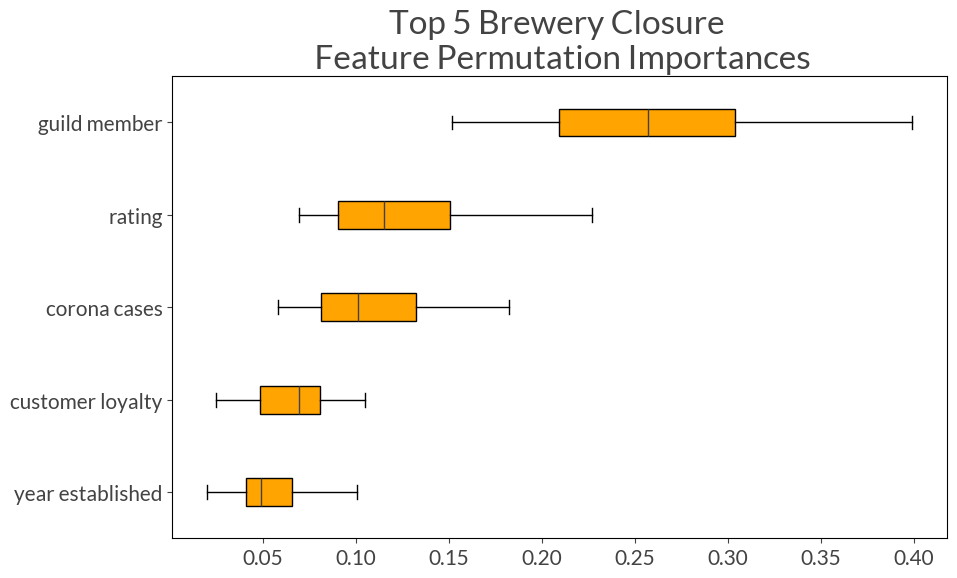

In [18]:
feature_names = dataDF.drop(columns=["closed_since_2022", "longitude", "latitude"]).columns
feature_names = np.array([' '.join(f.split("_")) for f in feature_names])
sorted_idx = perm_importance.importances_mean.argsort()

# plot feature importance in box plots using the given theme
fig, ax = plt.subplots(figsize=figsize_h)
ax.boxplot(perm_importance.importances[sorted_idx[-5:]].T, vert=False, labels=feature_names[sorted_idx[-5:]], patch_artist=True, medianprops=dict(color=col_off_black), boxprops=dict(facecolor=col_yellow), widths=0.3)
title = plt.title("Top 5 Brewery Closure \n Feature Permutation Importances", loc="center")
plt.show()

In [19]:
fig.savefig("Viz/Draft2/model_closure_svm.png", bbox_inches='tight')

## Reference

1. coronavirus cases until 2022 in Washington - https://www.wsha.org/for-patients/coronavirus/coronavirus-tracker/